<a href="https://colab.research.google.com/github/AnaJuvencio/Aprendizado_Profundo_Reconhecimento_Visual/blob/main/Projeto_Aprendizado_Profundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GPU + dependências

In [15]:
# Em Jupyter, você pode instalar direto pela célula (opcional):
# Se estiver em venv/conda, use o gerenciador do seu ambiente.
import sys
!{sys.executable} -m pip install -q tensorflow datasets scikit-learn pandas matplotlib


IMPORTS / SEEDS / CONFIGS

In [ ]:
# ==================== SEÇÃO 0. IMPORTS / SEEDS / CONFIGS ====================
import os, random, numpy as np
from pathlib import Path
import tensorflow as tf

# Reprodutibilidade
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# ⚠️ AJUSTE AQUI: caminho local do TrashNet (dataset-resized)
DATA_DIR = Path("./trashnet-master/data/dataset-resized")

# Hiperparâmetros
IMG_SIZE   = (160, 160)     # leve e suficiente pro TL
BATCH_SIZE = 16

print("TensorFlow:", tf.__version__)
print("GPU(s):", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.16.1
GPU(s): []


CARREGAR DATASET

In [19]:
# ==================== SEÇÃO 1. CARREGAR DATASET =============================
# 1) crie os datasets base SEM shuffle para poder ler class_names
train_base = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
valtest_base = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)

# 2) agora é seguro pegar os nomes das classes
CLASS_NAMES = train_base.class_names
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", CLASS_NAMES, "| Num classes:", NUM_CLASSES)

# 3) só depois faça o shuffle no treino
train_ds = train_base.shuffle(2048, seed=SEED)

# 4) divida validação/teste a partir do valtest_base
valtest_batches = int(tf.data.experimental.cardinality(valtest_base).numpy())
val_ds  = valtest_base.take(valtest_batches // 2)
test_ds = valtest_base.skip(valtest_batches // 2)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.
Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] | Num classes: 6


PREPROCESS + AUGMENT

In [20]:
# ==================== SEÇÃO 2. PREPROCESS + AUGMENT =========================
normalizer = tf.keras.layers.Rescaling(1./255)

augment = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),   # mais suave
    tf.keras.layers.RandomZoom(0.05),
], name="augmentation")

def prep_train(x, y):
    x = normalizer(x)
    x = augment(x, training=True)
    return x, y

def prep_eval(x, y):
    return normalizer(x), y

train_tf = train_ds.map(prep_train, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
val_tf   = val_ds.map(prep_eval,   num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)
test_tf  = test_ds.map(prep_eval,  num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

print("Pipelines prontos.")


Pipelines prontos.


Balanceamento: class weights

In [21]:
# ==================== SEÇÃO 3. CLASS WEIGHTS ================================
from glob import glob
counts = {i: len(glob(str(DATA_DIR / CLASS_NAMES[i] / "*"))) for i in range(NUM_CLASSES)}
total = sum(counts.values())
class_weight = {cls: total/(NUM_CLASSES * cnt) for cls, cnt in counts.items()}
print("Contagens:", counts)
print("Class weights:", class_weight)


Contagens: {0: 403, 1: 501, 2: 410, 3: 594, 4: 482, 5: 137}
Class weights: {0: 1.0450785773366418, 1: 0.8406520292747838, 2: 1.0272357723577237, 3: 0.7090347923681257, 4: 0.873789764868603, 5: 3.0742092457420926}


CNN baseline (simples)

In [ ]:
# ==================== SEÇÃO 4. CNN BASELINE ================================
from tensorflow import keras
from tensorflow.keras import layers, optimizers

def build_cnn_baseline(input_shape=(160,160,3), num_classes=NUM_CLASSES):
    m = keras.Sequential(name="cnn_baseline")
    m.add(layers.Conv2D(32, 3, padding="same", use_bias=False, input_shape=input_shape))
    m.add(layers.BatchNormalization()); m.add(layers.ReLU()); m.add(layers.MaxPooling2D())
    m.add(layers.Dropout(0.3))  # Regularização após 1º bloco conv

    m.add(layers.Conv2D(64, 3, padding="same", use_bias=False))
    m.add(layers.BatchNormalization()); m.add(layers.ReLU()); m.add(layers.MaxPooling2D())
    m.add(layers.Dropout(0.3))  # Regularização após 2º bloco conv

    m.add(layers.Conv2D(128, 3, padding="same", use_bias=False))
    m.add(layers.BatchNormalization()); m.add(layers.ReLU()); m.add(layers.MaxPooling2D())
    m.add(layers.Dropout(0.3))  # Regularização após 3º bloco conv

    # GAP (melhor que Flatten p/ generalizar)
    m.add(layers.GlobalAveragePooling2D())
    m.add(layers.Dense(256, activation="relu"))
    m.add(layers.Dropout(0.5))  # Dropout original na camada densa
    m.add(layers.Dense(num_classes, activation="softmax"))
    return m

cnn = build_cnn_baseline()

# LR menor + AdamW (estabiliza treinamento)
#base_lr = 3e-4
base_lr = 1e-4 
opt = optimizers.AdamW(learning_rate=base_lr, weight_decay=1e-4)
cnn.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
cnn.summary()

ckpt = keras.callbacks.ModelCheckpoint("cnn_baseline_best.keras",
                                       monitor="val_accuracy", save_best_only=True)
early = keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True)
reduce = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)

USE_CLASS_WEIGHT = False  # AJUSTAR AQUI: True/False
history_cnn = cnn.fit(
    train_tf,
    validation_data=val_tf,
    epochs=20,  # treino curto (baseline)
    callbacks=[ckpt, early, reduce],
    class_weight=class_weight if USE_CLASS_WEIGHT else None
)

c:\Users\Beatriz\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "cnn_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 160, 160, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_6 (ReLU)                  │ (None, 160, 160, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 80, 80, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_7 (ReLU)                  │ (None, 80, 80, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 40, 40, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_8 (ReLU)                  │ (None, 40, 40, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,486 (501.90 KB)

 Trainable params: 128,038 (500.15 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 76s 563ms/step - accuracy: 0.2574 - loss: 1.8173 - val_accuracy: 0.1719 - val_loss: 1.7922 - learning_rate: 1.0000e-04
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 76s 563ms/step - accuracy: 0.2574 - loss: 1.8173 - val_accuracy: 0.1719 - val_loss: 1.7922 - learning_rate: 1.0000e-04
Epoch 2/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 71s 548ms/step - accuracy: 0.4085 - loss: 1.4904 - val_accuracy: 0.1562 - val_loss: 1.8053 - learning_rate: 1.0000e-04
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 71s 548ms/step - accuracy: 0.4085 - loss: 1.4904 - val_accuracy: 0.1562 - val_loss: 1.8053 - learning_rate: 1.0000e-04
Epoch 3/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 69s 538ms/step - accuracy: 0.4506 - loss: 1.3970 - val_accuracy: 0.1719 - val_loss: 1.7271 - learning_rate: 1.0000e-04
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 69s 538ms/step - accuracy: 0.4506 - loss: 1.3970 - val_accuracy: 0.1719 - val_loss: 1.7271 - learning_rate: 1.0000e-04
Epoch 4/20
127/127 ━━━━━━━━━━━━━━━━━━━━ 71s 55

TRANSFER LEARNING (MOBILENETV2)

In [24]:
# ==================== SEÇÃO 5. TRANSFER LEARNING (MOBILENETV2) =============
base = tf.keras.applications.MobileNetV2(
    input_shape=(160,160,3), include_top=False, weights="imagenet"
)
base.trainable = False  # primeiro, congela

from tensorflow.keras import models
tl = models.Sequential([
    # Não faça Rescaling aqui (já normalizamos no pipeline)
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(NUM_CLASSES, activation="softmax")
], name="mobilenetv2_tl")

tl.compile(optimizer=optimizers.AdamW(1e-4, weight_decay=1e-4),
           loss="sparse_categorical_crossentropy", metrics=["accuracy"])

h1 = tl.fit(
    train_tf, validation_data=val_tf, epochs=8,
    callbacks=[keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)]
)

# Fine-tuning: descongela apenas o topo
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

tl.compile(optimizer=optimizers.AdamW(1e-4, weight_decay=1e-4),
           loss="sparse_categorical_crossentropy", metrics=["accuracy"])

h2 = tl.fit(
    train_tf, validation_data=val_tf, epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

tl_test = tl.evaluate(test_tf, verbose=0)[1]
print(f"[TL] Acurácia (teste): {tl_test:.4f}")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/8
Epoch 1/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 212ms/step - accuracy: 0.1778 - loss: 2.1324 - val_accuracy: 0.3438 - val_loss: 1.6277
Epoch 2/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 34s 212ms/step - accuracy: 0.1778 - loss: 2.1324 - val_accuracy: 0.3438 - val_loss: 1.6277
Epoch 2/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - accuracy: 0.3882 - loss: 1.5242 - val_accuracy: 0.4844 - val_loss: 1.3104
Epoch 3/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 208ms/step - accuracy: 0.3882 - loss: 1.5242 - val_accuracy: 0.4844 - val_loss: 1.3104
Epoch 3/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 192ms/step - accuracy: 0.5442 - loss: 1.2486 - val_accuracy: 0.5391 - val_loss: 1.1856
Epoch 4/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 192ms/step - accuracy: 0.5442 - loss: 1.2486 - val_accuracy: 0.5391 - val_loss: 1.1856
Epoch 4/8
127/127 ━━━━━━━━━━━━━━━━━━━━ 25s 190ms/step - accuracy: 0.5794 - loss: 1.1192 - val_accuracy: 0.6328 -

CURVAS E ARTEFATOS

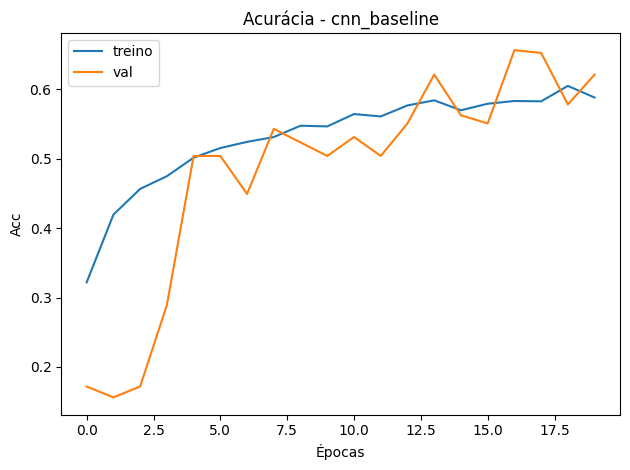

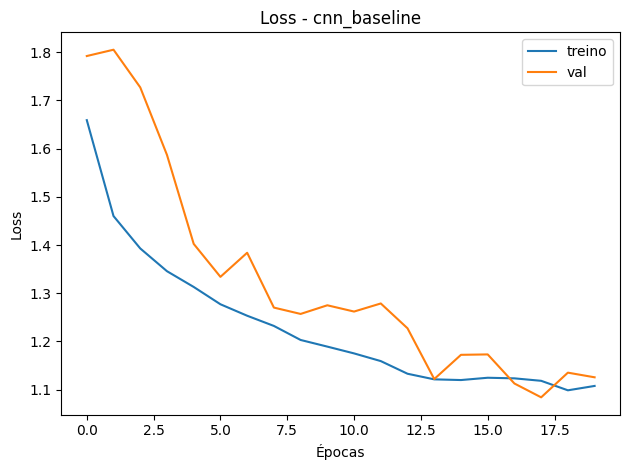

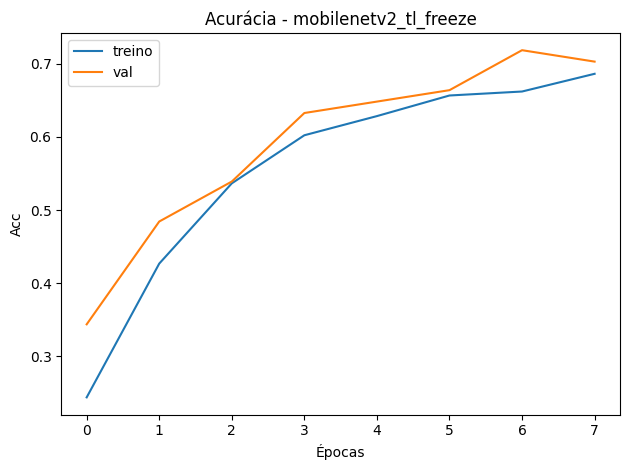

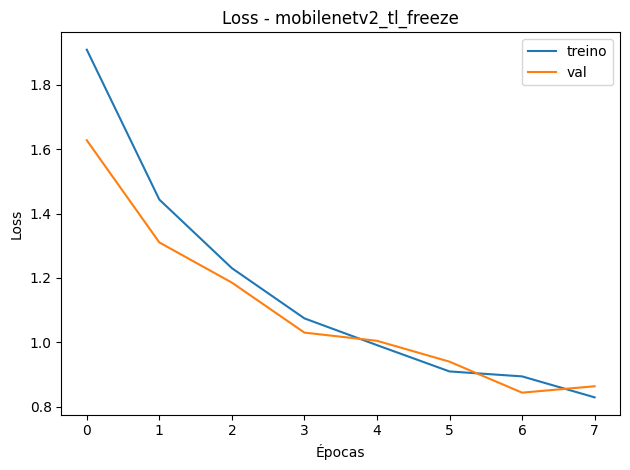

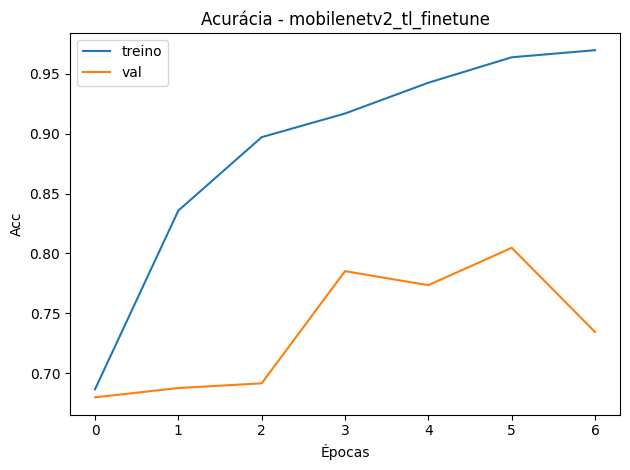

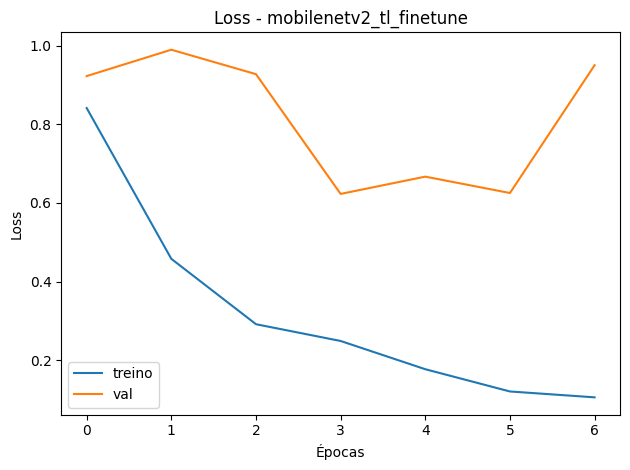

In [25]:
# ==================== SEÇÃO 6. CURVAS E ARTEFATOS ===========================
import pandas as pd, matplotlib.pyplot as plt

def plot_and_save(history, prefix):
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(f"{prefix}_history.csv", index=False)

    plt.figure()
    plt.plot(hist_df["accuracy"], label="treino")
    plt.plot(hist_df["val_accuracy"], label="val")
    plt.title(f"Acurácia - {prefix}"); plt.xlabel("Épocas"); plt.ylabel("Acc")
    plt.legend(); plt.tight_layout(); plt.savefig(f"acc_{prefix}.png", dpi=150); plt.show()

    plt.figure()
    plt.plot(hist_df["loss"], label="treino")
    plt.plot(hist_df["val_loss"], label="val")
    plt.title(f"Loss - {prefix}"); plt.xlabel("Épocas"); plt.ylabel("Loss")
    plt.legend(); plt.tight_layout(); plt.savefig(f"loss_{prefix}.png", dpi=150); plt.show()

plot_and_save(history_cnn, "cnn_baseline")

# Se treinou TL:
try:
    plot_and_save(h1, "mobilenetv2_tl_freeze")
    plot_and_save(h2, "mobilenetv2_tl_finetune")
except NameError:
    pass


Avaliação + matrizes


AVALIAÇÃO DO MODELO: CNN Baseline
Acurácia (teste): 0.5783
Loss (teste): 1.1819
Acurácia (teste): 0.5783
Loss (teste): 1.1819

Relatório de classificação - CNN Baseline:
              precision    recall  f1-score   support

   cardboard     0.6136    0.7941    0.6923        34
       glass     0.6176    0.4468    0.5185        47
       metal     0.7576    0.5952    0.6667        42
       paper     0.4902    0.8333    0.6173        60
     plastic     0.6667    0.4800    0.5581        50
       trash     0.0000    0.0000    0.0000        16

    accuracy                         0.5904       249
   macro avg     0.5243    0.5249    0.5088       249
weighted avg     0.5801    0.5904    0.5657       249


Relatório de classificação - CNN Baseline:
              precision    recall  f1-score   support

   cardboard     0.6136    0.7941    0.6923        34
       glass     0.6176    0.4468    0.5185        47
       metal     0.7576    0.5952    0.6667        42
       paper     0.4902  

c:\Users\Beatriz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Beatriz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Beatriz\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

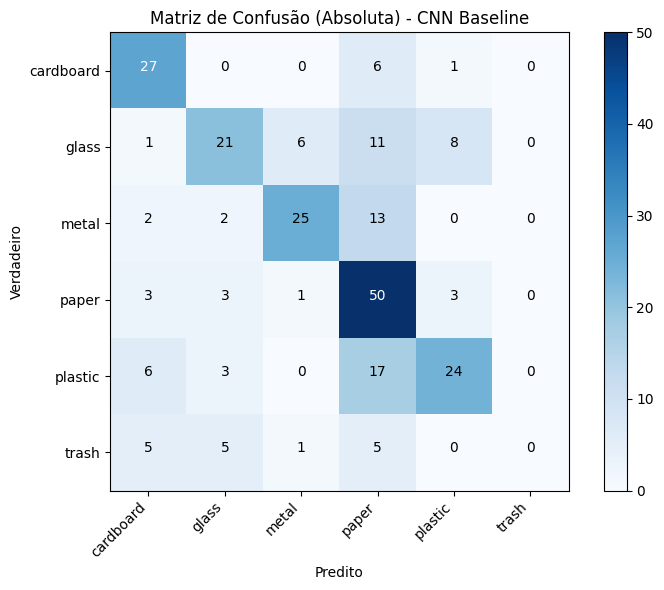

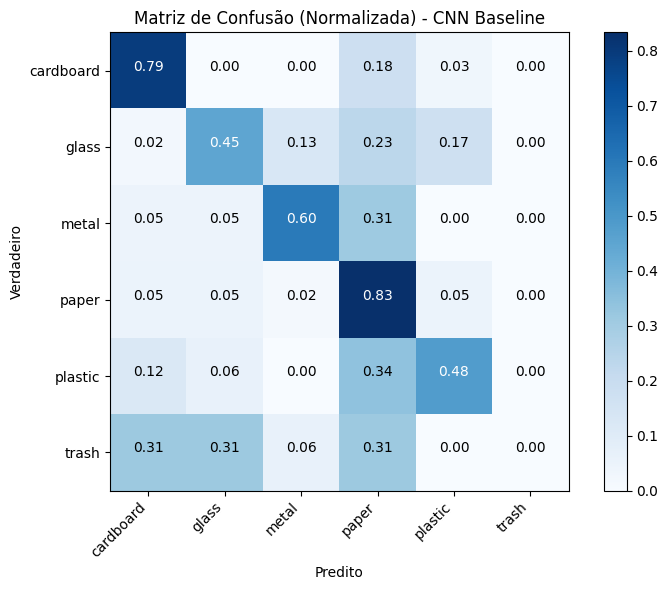


AVALIAÇÃO DO MODELO: MobileNetV2 TL
Acurácia (teste): 0.7871
Loss (teste): 0.5292
Acurácia (teste): 0.7871
Loss (teste): 0.5292

Relatório de classificação - MobileNetV2 TL:
              precision    recall  f1-score   support

   cardboard     0.8182    0.7941    0.8060        34
       glass     0.7872    0.7255    0.7551        51
       metal     0.8824    0.7317    0.8000        41
       paper     0.8387    0.8525    0.8455        61
     plastic     0.7059    0.8000    0.7500        45
       trash     0.5455    0.7059    0.6154        17

    accuracy                         0.7791       249
   macro avg     0.7630    0.7683    0.7620       249
weighted avg     0.7885    0.7791    0.7811       249


Relatório de classificação - MobileNetV2 TL:
              precision    recall  f1-score   support

   cardboard     0.8182    0.7941    0.8060        34
       glass     0.7872    0.7255    0.7551        51
       metal     0.8824    0.7317    0.8000        41
       paper     0.

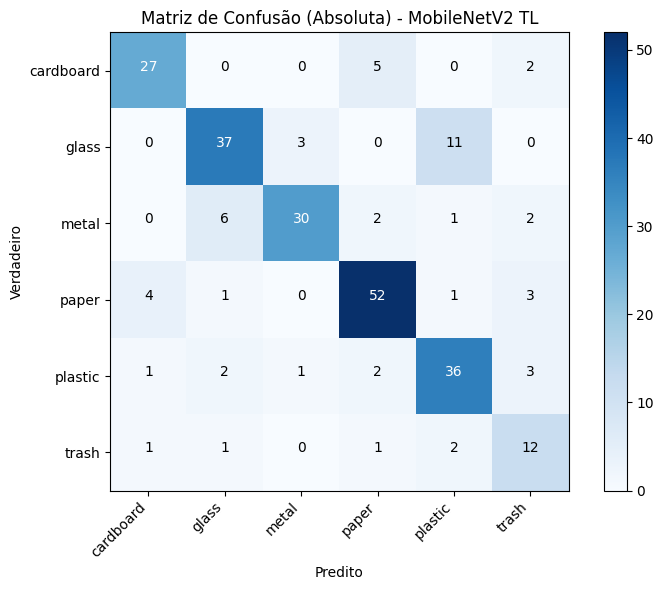

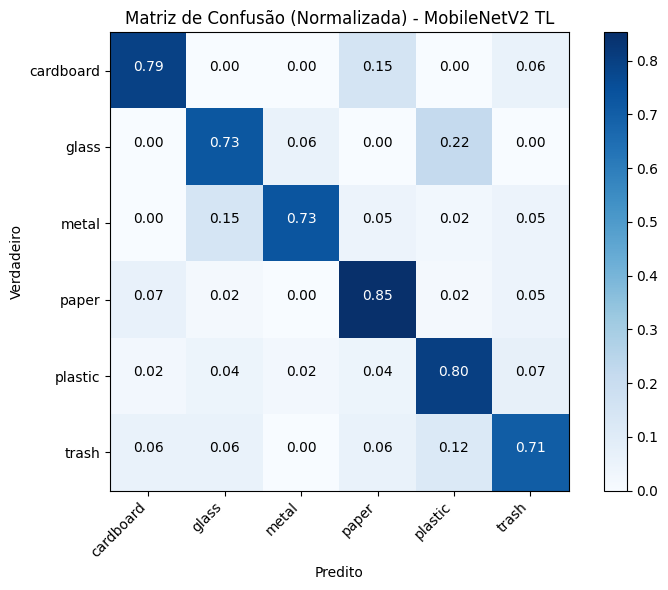


RESUMO COMPARATIVO DOS MODELOS
MobileNetV2 TL      : 0.7871 (78.71%)
CNN Baseline        : 0.5783 (57.83%)

🏆 MELHOR MODELO: MobileNetV2 TL com 0.7871 de acurácia
📊 Diferença de performance: 0.2088 (20.88 pontos percentuais)


In [26]:
# ==================== SEÇÃO 7. AVALIAÇÃO + MATRIZES ========================
import numpy as np, itertools
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import pandas as pd, matplotlib.pyplot as plt

def evaluate_model(model, model_name):
    """Função para avaliar um modelo e gerar relatórios"""
    print(f"\n{'='*60}")
    print(f"AVALIAÇÃO DO MODELO: {model_name}")
    print(f"{'='*60}")
    
    # Acurácia no teste
    test_loss, test_acc = model.evaluate(test_tf, verbose=0)
    print(f"Acurácia (teste): {test_acc:.4f}")
    print(f"Loss (teste): {test_loss:.4f}")
    
    # Predições
    y_true, y_pred = [], []
    for x, y in test_tf:
        p = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(p, axis=1))
        y_true.extend(y.numpy())
    
    # Relatório de classificação
    print(f"\nRelatório de classificação - {model_name}:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))
    
    # Salvar métricas por classe
    prec, rec, f1, sup = precision_recall_fscore_support(y_true, y_pred, labels=range(NUM_CLASSES))
    df_metrics = pd.DataFrame({
        "class": CLASS_NAMES, 
        "precision": prec, 
        "recall": rec, 
        "f1": f1, 
        "support": sup
    })
    df_metrics.to_csv(f"class_report_{model_name.lower().replace(' ', '_')}.csv", index=False)
    
    # Matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    cmn = cm.astype("float") / cm.sum(axis=1, keepdims=True)
    
    # Plot matrizes de confusão
    def plot_cm(M, title, fname, fmt="d"):
        plt.figure(figsize=(8, 6))
        plt.imshow(M, interpolation="nearest", cmap=plt.cm.Blues)
        plt.title(f"{title} - {model_name}")
        plt.colorbar()
        ticks = np.arange(NUM_CLASSES)
        plt.xticks(ticks, CLASS_NAMES, rotation=45, ha="right")
        plt.yticks(ticks, CLASS_NAMES)
        th = M.max() / 2.
        for i, j in itertools.product(range(M.shape[0]), range(M.shape[1])):
            txt = f"{M[i,j]:.2f}" if fmt=="0.2f" else f"{int(M[i,j])}"
            plt.text(j, i, txt, ha="center", color="white" if M[i,j] > th else "black")
        plt.ylabel("Verdadeiro")
        plt.xlabel("Predito")
        plt.tight_layout()
        plt.savefig(fname, dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plotar ambas as matrizes
    model_suffix = model_name.lower().replace(' ', '_')
    plot_cm(cm, "Matriz de Confusão (Absoluta)", f"cm_abs_{model_suffix}.png", fmt="d")
    plot_cm(cmn, "Matriz de Confusão (Normalizada)", f"cm_norm_{model_suffix}.png", fmt="0.2f")
    
    return test_acc, df_metrics

# ==================== AVALIAR AMBOS OS MODELOS =============================

# Lista para armazenar resultados comparativos
results_summary = []

# 1. Avaliar CNN Baseline
if 'cnn' in globals():
    cnn_acc, cnn_metrics = evaluate_model(cnn, "CNN Baseline")
    results_summary.append({"Modelo": "CNN Baseline", "Acurácia": cnn_acc})
else:
    print("⚠️ CNN Baseline não encontrada. Execute a célula de treino da CNN primeiro.")

# 2. Avaliar MobileNetV2 Transfer Learning
if 'tl' in globals():
    tl_acc, tl_metrics = evaluate_model(tl, "MobileNetV2 TL")
    results_summary.append({"Modelo": "MobileNetV2 TL", "Acurácia": tl_acc})
else:
    print("⚠️ MobileNetV2 TL não encontrado. Execute a célula de Transfer Learning primeiro.")

# ==================== COMPARAÇÃO FINAL =====================================
if results_summary:
    print(f"\n{'='*60}")
    print("RESUMO COMPARATIVO DOS MODELOS")
    print(f"{'='*60}")
    
    df_comparison = pd.DataFrame(results_summary)
    df_comparison = df_comparison.sort_values('Acurácia', ascending=False)
    
    for _, row in df_comparison.iterrows():
        print(f"{row['Modelo']:20s}: {row['Acurácia']:.4f} ({row['Acurácia']*100:.2f}%)")
    
    # Salvar comparação
    df_comparison.to_csv("models_comparison.csv", index=False)
    
    # Melhor modelo
    best_model = df_comparison.iloc[0]
    print(f"\n🏆 MELHOR MODELO: {best_model['Modelo']} com {best_model['Acurácia']:.4f} de acurácia")
    
    # Diferença de performance
    if len(df_comparison) > 1:
        diff = df_comparison.iloc[0]['Acurácia'] - df_comparison.iloc[1]['Acurácia']
        print(f"📊 Diferença de performance: {diff:.4f} ({diff*100:.2f} pontos percentuais)")

## Organizar Resultados

In [7]:
# ==================== ORGANIZAR E SALVAR RESULTADOS ========================
import os
import shutil
from pathlib import Path
from datetime import datetime

# Obter configurações das variáveis globais (se existirem)
try:
    img_size = IMG_SIZE
    batch_size = BATCH_SIZE
    lr = base_lr
    use_class_weight = USE_CLASS_WEIGHT
except NameError:
    # Valores padrão se as variáveis não estiverem definidas
    print("⚠️ Algumas variáveis não foram encontradas. Usando valores padrão...")
    img_size = (160, 160)
    batch_size = 16
    lr = 1e-4
    use_class_weight = False

# Definir nome do experimento baseado na configuração
EXPERIMENT_NAME = f"baseline_{img_size[0]}x{img_size[1]}_lr{lr:.0e}_bs{batch_size}"
if use_class_weight:
    EXPERIMENT_NAME += "_classweight"

print(f"📊 ORGANIZANDO RESULTADOS DO EXPERIMENTO: {EXPERIMENT_NAME}")

# Verificar onde os arquivos estão atualmente
current_dir = Path(".")
results_dir = Path("results")

print(f"\n🔍 VERIFICANDO ARQUIVOS:")

# Criar estrutura para este experimento específico
EXPERIMENT_DIR = results_dir / EXPERIMENT_NAME
MODELS_DIR = EXPERIMENT_DIR / "models"
PLOTS_DIR = EXPERIMENT_DIR / "plots"
HISTORY_DIR = EXPERIMENT_DIR / "history"
REPORTS_DIR = EXPERIMENT_DIR / "reports"

# Criar pastas para este experimento
for folder in [EXPERIMENT_DIR, MODELS_DIR, PLOTS_DIR, HISTORY_DIR, REPORTS_DIR]:
    folder.mkdir(parents=True, exist_ok=True)

print(f"📁 Pasta do experimento: {EXPERIMENT_DIR}")

# Mapear arquivos da estrutura existente para a nova estrutura
files_to_copy = []
copied_files = []

# 1. Verificar arquivos no diretório raiz
root_files = {
    "cnn_baseline_best.keras": MODELS_DIR,
    "cnn_baseline_history.csv": HISTORY_DIR,
    "mobilenetv2_tl_freeze_history.csv": HISTORY_DIR,
    "mobilenetv2_tl_finetune_history.csv": HISTORY_DIR,
    "acc_cnn_baseline.png": PLOTS_DIR,
    "loss_cnn_baseline.png": PLOTS_DIR,
    "acc_mobilenetv2_tl_freeze.png": PLOTS_DIR,
    "loss_mobilenetv2_tl_freeze.png": PLOTS_DIR,
    "acc_mobilenetv2_tl_finetune.png": PLOTS_DIR,
    "loss_mobilenetv2_tl_finetune.png": PLOTS_DIR,
    "cm_abs_cnn_baseline.png": PLOTS_DIR,
    "cm_norm_cnn_baseline.png": PLOTS_DIR,
    "cm_abs_mobilenetv2_tl.png": PLOTS_DIR,
    "cm_norm_mobilenetv2_tl.png": PLOTS_DIR,
    "class_report_cnn_baseline.csv": REPORTS_DIR,
    "class_report_mobilenetv2_tl.csv": REPORTS_DIR,
    "models_comparison.csv": REPORTS_DIR,
}

print(f"\n📦 COPIANDO ARQUIVOS:")

# Copiar do diretório raiz
for filename, dest_folder in root_files.items():
    source_path = current_dir / filename
    if source_path.exists():
        dest_path = dest_folder / filename
        shutil.copy2(str(source_path), str(dest_path))
        copied_files.append(f"  ✅ {filename} → {dest_folder.name}/")
        print(f"  ✅ RAIZ: {filename} → {dest_folder.name}/")

# 2. Copiar da estrutura organizada existente (results/models/, results/plots/, etc.)
if results_dir.exists():
    # Modelos
    models_src = results_dir / "models"
    if models_src.exists():
        for file in models_src.glob("*.keras"):
            dest_path = MODELS_DIR / file.name
            shutil.copy2(str(file), str(dest_path))
            copied_files.append(f"  ✅ {file.name} → models/")
            print(f"  ✅ MODELS: {file.name} → models/")
    
    # Históricos
    history_src = results_dir / "history"
    if history_src.exists():
        for file in history_src.glob("*.csv"):
            dest_path = HISTORY_DIR / file.name
            shutil.copy2(str(file), str(dest_path))
            copied_files.append(f"  ✅ {file.name} → history/")
            print(f"  ✅ HISTORY: {file.name} → history/")
    
    # Relatórios
    reports_src = results_dir / "reports"
    if reports_src.exists():
        for file in reports_src.glob("*.csv"):
            dest_path = REPORTS_DIR / file.name
            shutil.copy2(str(file), str(dest_path))
            copied_files.append(f"  ✅ {file.name} → reports/")
            print(f"  ✅ REPORTS: {file.name} → reports/")
    
    # Gráficos (estrutura mais complexa)
    plots_src = results_dir / "plots"
    if plots_src.exists():
        # Accuracy plots
        acc_dir = plots_src / "accuracy"
        if acc_dir.exists():
            for file in acc_dir.glob("*.png"):
                dest_path = PLOTS_DIR / file.name
                shutil.copy2(str(file), str(dest_path))
                copied_files.append(f"  ✅ {file.name} → plots/")
                print(f"  ✅ ACCURACY: {file.name} → plots/")
        
        # Loss plots
        loss_dir = plots_src / "loss"
        if loss_dir.exists():
            for file in loss_dir.glob("*.png"):
                dest_path = PLOTS_DIR / file.name
                shutil.copy2(str(file), str(dest_path))
                copied_files.append(f"  ✅ {file.name} → plots/")
                print(f"  ✅ LOSS: {file.name} → plots/")
        
        # Confusion matrices
        cm_dir = plots_src / "confusion_matrices"
        if cm_dir.exists():
            for file in cm_dir.glob("*.png"):
                dest_path = PLOTS_DIR / file.name
                shutil.copy2(str(file), str(dest_path))
                copied_files.append(f"  ✅ {file.name} → plots/")
                print(f"  ✅ CONFUSION: {file.name} → plots/")

# Obter resultados das variáveis (se existirem)
try:
    cnn_accuracy = cnn_acc if 'cnn_acc' in globals() else "N/A"
    tl_accuracy = tl_acc if 'tl_acc' in globals() else "N/A"
    best_model_name = best_model['Modelo'] if 'best_model' in globals() else "N/A"
    performance_diff = f"{diff:.4f}" if 'diff' in globals() else "N/A"
except NameError:
    cnn_accuracy = "N/A"
    tl_accuracy = "N/A"
    best_model_name = "N/A"
    performance_diff = "N/A"

# Salvar resumo do experimento
experiment_summary = {
    "experimento": EXPERIMENT_NAME,
    "data": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "configuracao": {
        "IMG_SIZE": img_size,
        "BATCH_SIZE": batch_size,
        "base_lr": lr,
        "USE_CLASS_WEIGHT": use_class_weight,
        "epochs_cnn": 20,
        "epochs_tl_freeze": 8,
        "epochs_tl_finetune": 10,
    },
    "resultados": {
        "cnn_baseline_acc": cnn_accuracy,
        "mobilenetv2_tl_acc": tl_accuracy,
        "melhor_modelo": best_model_name,
        "diferenca_performance": performance_diff,
    },
    "arquivos_copiados": copied_files
}

# Salvar como JSON
import json
summary_path = EXPERIMENT_DIR / "experiment_summary.json"
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(experiment_summary, f, indent=2, ensure_ascii=False)

print(f"\n📋 RESUMO SALVO: {summary_path}")

# Listar arquivos na pasta final
final_files = list(EXPERIMENT_DIR.rglob("*"))
final_count = len([f for f in final_files if f.is_file()])

print(f"\n🎯 RESULTADO FINAL:")
print(f"📂 Experimento: {EXPERIMENT_NAME}")
print(f"📁 Pasta: {EXPERIMENT_DIR}")
print(f"📦 Total de arquivos copiados: {len(copied_files)}")
print(f"📄 Total de arquivos na pasta final: {final_count}")

# Verificar conteúdo das subpastas
for subdir in [MODELS_DIR, PLOTS_DIR, HISTORY_DIR, REPORTS_DIR]:
    files = [f for f in subdir.glob("*") if f.is_file()]
    if files:
        print(f"  📂 {subdir.name}/: {len(files)} arquivos")
        for file in files[:3]:  # Mostrar apenas os primeiros 3
            print(f"    📄 {file.name}")
        if len(files) > 3:
            print(f"    ... e mais {len(files)-3} arquivos")

print(f"\n✅ EXPERIMENTO '{EXPERIMENT_NAME}' ORGANIZADO COM SUCESSO!")

⚠️ Algumas variáveis não foram encontradas. Usando valores padrão...
📊 ORGANIZANDO RESULTADOS DO EXPERIMENTO: baseline_160x160_lr1e-04_bs16

🔍 VERIFICANDO ARQUIVOS:
📁 Pasta do experimento: results\baseline_160x160_lr1e-04_bs16

📦 COPIANDO ARQUIVOS:
  ✅ MODELS: cnn_baseline_best.keras → models/
  ✅ HISTORY: cnn_baseline_history.csv → history/
  ✅ HISTORY: mobilenetv2_tl_finetune_history.csv → history/
  ✅ HISTORY: mobilenetv2_tl_freeze_history.csv → history/
  ✅ REPORTS: class_report_cnn_baseline.csv → reports/
  ✅ REPORTS: class_report_mobilenetv2_tl.csv → reports/
  ✅ REPORTS: models_comparison.csv → reports/
  ✅ ACCURACY: acc_cnn_baseline.png → plots/
  ✅ ACCURACY: acc_mobilenetv2_tl_finetune.png → plots/
  ✅ ACCURACY: acc_mobilenetv2_tl_freeze.png → plots/
  ✅ LOSS: loss_cnn_baseline.png → plots/
  ✅ LOSS: loss_mobilenetv2_tl_finetune.png → plots/
  ✅ LOSS: loss_mobilenetv2_tl_freeze.png → plots/
  ✅ CONFUSION: cm_abs_cnn_baseline.png → plots/
  ✅ CONFUSION: cm_abs_mobilenetv2_tl.pn

Limpar arquivo:

In [27]:
# Limpar metadados do notebook para melhor compatibilidade
import json
import os

# Função para limpar metadados problemáticos
def clean_notebook(notebook_path):
    with open(notebook_path, 'r', encoding='utf-8') as f:
        nb = json.load(f)
    
    # Remover metadados problemáticos
    if 'metadata' in nb:
        # Manter apenas metadados essenciais
        essential_metadata = {}
        if 'kernelspec' in nb['metadata']:
            essential_metadata['kernelspec'] = nb['metadata']['kernelspec']
        if 'language_info' in nb['metadata']:
            essential_metadata['language_info'] = nb['metadata']['language_info']
        nb['metadata'] = essential_metadata
    
    # Limpar metadados das células
    for cell in nb.get('cells', []):
        if 'metadata' in cell:
            # Manter apenas metadados essenciais da célula
            cell['metadata'] = {}
    
    # Salvar notebook limpo
    clean_path = notebook_path.replace('.ipynb', '_clean.ipynb')
    with open(clean_path, 'w', encoding='utf-8') as f:
        json.dump(nb, f, indent=1, ensure_ascii=False)
    
    print(f"Notebook limpo salvo como: {clean_path}")
    return clean_path

# Limpar o notebook atual
notebook_path = "Projeto_Aprendizado_Profundo.ipynb"
if os.path.exists(notebook_path):
    clean_notebook(notebook_path)
else:
    print(f"Arquivo {notebook_path} não encontrado!")

Notebook limpo salvo como: Projeto_Aprendizado_Profundo_clean.ipynb
